In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
cd \

C:\


In [3]:
cd Penn State\Projects\Lane Detection\Dataset

C:\Penn State\Projects\Lane Detection\Dataset


In [4]:
import os
os.getcwd()

'C:\\Penn State\\Projects\\Lane Detection\\Dataset'

In [5]:
import pandas as pd
import numpy as np
import keras
import h5py
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import itertools
from keras.preprocessing import image
from keras.layers.core import Dropout, Lambda
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Add, Flatten, UpSampling2D, BatchNormalization
from keras.layers import Dense, Activation, Flatten, Dropout, concatenate, Input
from keras.optimizers import Adam, Adadelta
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers.advanced_activations import LeakyReLU
#from keras.layers.convolutional import Deconvolution2D

Using TensorFlow backend.


# Import data from system to numpy array

In [8]:
%%time

train = []

for file in os.listdir(os.path.join(os.getcwd(), 'RGB_data')):
    train.append([os.path.join(os.getcwd(), 'RGB_data', file),
                     os.path.join(os.getcwd(), 'Segmented_data', file)])
train = pd.DataFrame(train, columns=['Camera_Image', 'Segmented_Images'])

Augmented_data = []

for file in os.listdir(os.path.join(os.getcwd(), 'Augmented_RGB')):
    Augmented_data.append([os.path.join(os.getcwd(), 'Augmented_RGB', file),
                     os.path.join(os.getcwd(), 'Augmented_Seg', file)])
    
Augmented_data = pd.DataFrame(Augmented_data, columns=['Camera_Image', 'Segmented_Images'])

Train_data = [train, Augmented_data]
Train_data = pd.concat(Train_data)

#Shuffle the data
Train_data = Train_data.sample(frac=1).reset_index(drop=True)

x_train = []
y_train= []

for i in range(len(Train_data)):
    img = cv2.imread(Train_data.iloc[i][0])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    x_train.append(img)
    img = cv2.imread(Train_data.iloc[i][1])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    y_train.append(img)
    if i%999 == 0:
        print(i," images are done")
    
x_train = np.array(x_train) #Camera RGB data
y_train = np.array(y_train) #Segmented data

0  images are done
999  images are done
1998  images are done
2997  images are done
Wall time: 36.9 s


In [9]:
del train
del Augmented_data
del Train_data

# Train image

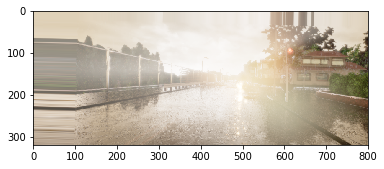

In [10]:
plt.imshow(x_train[299])

# Segmented Image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


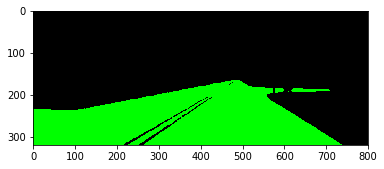

In [11]:
import math
def encoded_to_colored(image):
    x_visual= np.zeros((320, 800, 3), dtype = float)
    #image = skyHoodRemove(image)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if math.floor(max(image[i][j] )) == 1:
                x_visual[i][j] = [0.,0.,0.]
            else :
                x_visual[i][j] = [0., 255., 0.]
                
    
    return x_visual
plt.imshow(encoded_to_colored(y_train[299]))

# Split data into train and test set

In [12]:
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size = 0.1, random_state=125)

In [13]:
print('Shape of Training data: ', x_train.shape, '  Shape of Training label: ', y_train.shape)

Shape of Training data:  (2700, 320, 800, 3)   Shape of Training label:  (2700, 320, 800, 3)


In [14]:
print('Shape of Test data: ', x_test.shape, '  Shape of Test label: ', y_test.shape)

Shape of Test data:  (300, 320, 800, 3)   Shape of Test label:  (300, 320, 800, 3)


# Metric

In [56]:
from keras import backend as K
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

"""def mean_iou(y_true, y_pred):
    y_pred_ = tf.to_int32(y_pred > 0.75)
    score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
    K.get_session().run(tf.local_variables_initializer())
    with tf.control_dependencies([up_opt]):
        score = tf.identity(score)
    return score"""

'def mean_iou(y_true, y_pred):\n    y_pred_ = tf.to_int32(y_pred > 0.75)\n    score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)\n    K.get_session().run(tf.local_variables_initializer())\n    with tf.control_dependencies([up_opt]):\n        score = tf.identity(score)\n    return score'

# Build the Model

In [57]:
image_input=Input(shape=(320, 800, 3))

In [58]:
from keras.layers import *

def GCN(c, k, ip):
    k= 11 #Set size of filter manuually for GCN block
    G_L1 = Conv2D(c, (k,1), padding='same')(ip)
    G_L2 = Conv2D(c, (1,k), padding='same')(G_L1)
    G_R1 = Conv2D(c, (1,k), padding='same')(ip)
    #print(G_R1.shape)
    G_R2 = Conv2D(c, (k,1), padding='same')(G_R1)
    #print(G_R1.shape)
    return Add()([G_L2, G_R2])


def BR(c, k, ip):
    B_L1 = Conv2D(c, (k,1), padding='same')(ip)
    B_L2 = BatchNormalization()(B_L1)
    B_L2 = LeakyReLU(alpha=0.15)(B_L2)
    B_L3 = Conv2D(c, (k,1), padding='same')(B_L2)
    return Add()([B_L3, ip])

def Conv_block(inp, f1, f2):
    x = Conv2D(f1, (3,3), padding = 'same')(inp)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.3)(x)
    x = Conv2D(f2, (3,3), padding = 'same', activation= 'relu')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.3)(x)
    ###Pooling
    x = MaxPooling2D(pool_size=(2,2))(x)
    return x



#Input
ip = Input(shape=(320, 800, 3))

#Conv Block1
x1 = Conv_block(ip, 4, 10)
#print(x1)

#Conv Layer2
x2 = Conv_block(x1, 8, 15)
#print(x2)

#Conv Layer3
x3 = Conv_block(x2, 16, 20)
#print(x3)


#Conv Layer4
x4 = Conv_block(x3, 32, 30)
#print(x4)

#Conv Layer5
x5 = Conv2D(40, (3,3), padding = 'same')(x4)
x5 = BatchNormalization()(x5)
x5 = LeakyReLU(alpha=0.3)(x5)
x5 = Conv2D(50, (3,3), padding = 'same', activation= 'relu')(x5)

#print(x5)
x5 = GCN(30, 3, x5)
x5 = BR(30, 3, x5)


#Deconv5
x5 = BatchNormalization()(x5)
x5 = LeakyReLU(alpha=0.3)(x5)
#print(x5)

#Add 4 and 5
x5 = Add()([x5, x4])
x5 = GCN(25, 3, x5)
x5 = BR(25, 3, x5)

#print(x5)
#Deconv4
x5 = Conv2DTranspose(20, (3,3), strides=(2, 2), padding='same')(x5)
x5 = BatchNormalization()(x5)
x5 = LeakyReLU(alpha=0.3)(x5)
#print(x5)

#Add 5 and 3
x5 = Add()([x5, x3])
x5 = GCN(25, 3, x5)
x5 = BR(25, 3, x5)


#Deconv3
x5 = Conv2DTranspose(15, (3,3), strides=(2, 2), padding='same')(x5)
x5 = BatchNormalization()(x5)
x5 = LeakyReLU(alpha=0.3)(x5)

#Add 2 and 5
x5 = Add()([x5, x2])
x5 = GCN(20, 3, x5)
x5 = BR(20, 3, x5)


#Deconv2
x5 = Conv2DTranspose(10, (3,3), strides=(2, 2), padding='same')(x5)
x5 = BatchNormalization()(x5)
x5 = LeakyReLU(alpha=0.3)(x5)

#Add 1 and 5
x5 = Add()([x5, x1])
x5 = GCN(15, 3, x5)
x5 = BR(15, 3, x5)


#Deconv1
x5 = Conv2DTranspose(3, (3,3), strides=(2, 2), padding='same')(x5)
x5 = BatchNormalization()(x5)
x5 = LeakyReLU(alpha=0.3)(x5)
x5 = GCN(3, 3, x5)
x5 = BR(3, 3, x5)
x5 = Conv2D(3, (1, 1), activation='sigmoid') (x5)

model_new = Model(ip, x5)
model_new.summary()
 

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 320, 800, 3)  0                                            
__________________________________________________________________________________________________
conv2d_103 (Conv2D)             (None, 320, 800, 4)  112         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_33 (BatchNo (None, 320, 800, 4)  16          conv2d_103[0][0]                 
__________________________________________________________________________________________________
leaky_re_lu_41 (LeakyReLU)      (None, 320, 800, 4)  0           batch_normalization_33[0][0]     
__________________________________________________________________________________________________
conv2d_104

In [59]:
from keras.metrics import categorical_accuracy
from keras import optimizers

# Compile and train the model

In [60]:
model_new.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['binary_accuracy',mean_iou])
earlystopper = EarlyStopping(monitor='val_mean_iou', min_delta=0.005, patience=0, verbose=1, mode = 'max')
checkpoint =ModelCheckpoint(filepath='Lane_Model_ GCN -Version1/weights.{epoch:02d}-{val_loss:.2f}.hdf5',
    monitor='val_mean_iou',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode='max',
    period=3)

In [61]:
history = model_new.fit(x_train, y_train, epochs=100, batch_size=16, validation_split=0.1, callbacks=[earlystopper, checkpoint], 
                        shuffle=False)

Train on 2430 samples, validate on 270 samples
Epoch 1/100
2430/2430 [==============================] - 216s 89ms/step - loss: 0.2779 - binary_accuracy: 0.8677 - mean_iou: 0.4034 - val_loss: 0.1137 - val_binary_accuracy: 0.9596 - val_mean_iou: 0.6218
Epoch 2/100
2430/2430 [==============================] - 202s 83ms/step - loss: 0.0687 - binary_accuracy: 0.9758 - mean_iou: 0.6988 - val_loss: 0.0665 - val_binary_accuracy: 0.9780 - val_mean_iou: 0.7516
Epoch 3/100
2430/2430 [==============================] - 201s 83ms/step - loss: 0.0509 - binary_accuracy: 0.9817 - mean_iou: 0.7823 - val_loss: 0.0544 - val_binary_accuracy: 0.9804 - val_mean_iou: 0.8069

Epoch 00003: val_mean_iou improved from -inf to 0.80689, saving model to Lane_Model_ GCN -Version1/weights.03-0.05.hdf5
Epoch 4/100
2430/2430 [==============================] - 203s 84ms/step - loss: 0.0418 - binary_accuracy: 0.9846 - mean_iou: 0.8241 - val_loss: 0.0433 - val_binary_accuracy: 0.9843 - val_mean_iou: 0.8388
Epoch 5/100
2430

In [62]:
model_new.save('Lane_Model_ GCN -Version1\Lane_MOdel_U_GCN_version1.h5')

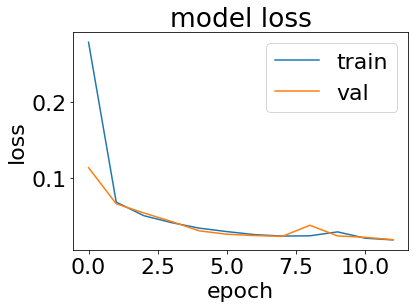

In [63]:
import matplotlib.pyplot as plt
%matplotlib inline
#plt.rcParams["figure.figsize"] = (15,10)
plt.rcParams.update({'font.size': 22})
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.savefig('Lane_Model_ GCN -Version1\Errorvs Epoch.png')

# Test set analysis

In [64]:
y_pred = model_new.predict(x_test, batch_size=16, verbose=2, steps=None)

In [65]:
test_eval = model_new.evaluate(x_test, y_test, batch_size=20, verbose=1, sample_weight=None)

300/300 [==============================] - 19s 62ms/step


In [70]:
print('Test mIOU: ',test_eval[2])
print('Test Binary Accuracy: ',test_eval[1])

Test mIOU:  0.9204924861590068
Test Binary Accuracy:  0.992479121685028


# Visualizations of test set images

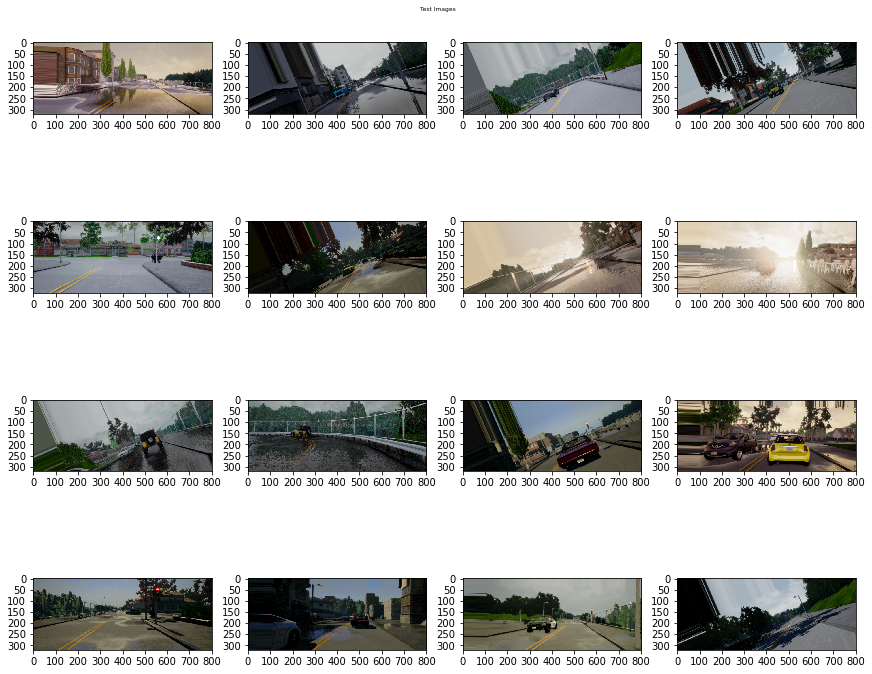

In [72]:
from random import randint

x = [randint(0, len(x_test)) for p in range(16)]
f, axs = plt.subplots(4,4, figsize=(12,10))
plt.rcParams["figure.figsize"] = (15,10)
plt.rcParams.update({'font.size': 5})
f.tight_layout()
f.suptitle('Test Images')
for i, ax in enumerate(axs.ravel()):
    ax.grid('off')
    ax.imshow(x_test[i])

# Corresponding Model generated segmented images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

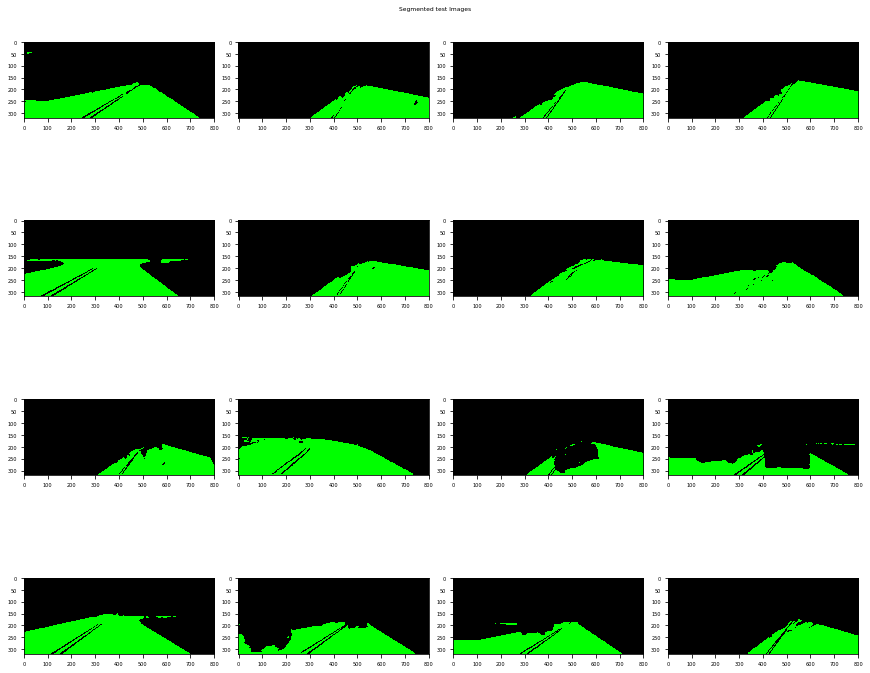

In [73]:
f, axs = plt.subplots(4,4, figsize=(12,10))
plt.rcParams.update({'font.size': 5})
f.tight_layout()
f.suptitle('Segmented test Images')
for i, ax in enumerate(axs.ravel()):
    ax.grid('off')
    
    ax.imshow(encoded_to_colored(y_pred[i]>0.35))

# Model generated image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


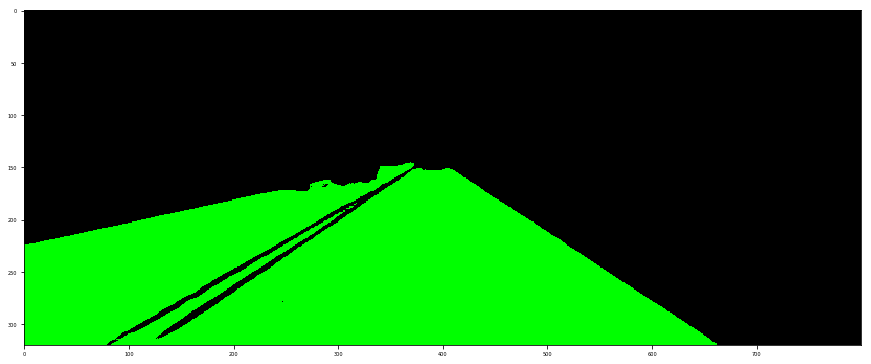

In [82]:
plt.imshow(encoded_to_colored(y_pred[288] > 0.35))


# Corresponding label image 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


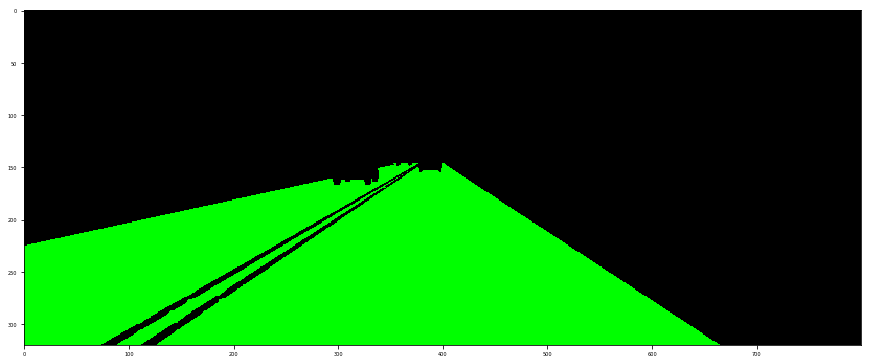

In [75]:
plt.imshow(encoded_to_colored(y_test[288]))